### CONFIGURATION

In [41]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 1000)
import numpy as np
import copy
import sys
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Hartwig imports
sys.path.append("/Users/peterpriestley/hmf/repos/scripts/analysisscripts") 
import analyseVCF as aVCF
import venn as vn

In [3]:
#CHROM SLICING
minChromFrac = 0
maxChromFrac = 26

In [57]:
# BED FILE
BED_PATH = "/Users/peterpriestley/hmf/analyses/giabTruthsets/70-30mixin/"
BED_FILE_NAME = "na12878-na24385-somatic-truth-regionsSORTED.bed"

# TRUTH SET
SAMPLE_NAMES_TRUTH = {'NA12878':'truth'}
VCF_PATH_TRUTH = "/Users/peterpriestley/hmf/analyses/giabTruthsets/70-30mixin/"
VCF_FILE_NAME_TRUTH = "na12878-na24385-somatic-truth.vcf"

# COMBINED VCF CONFIG
VCF_SAMPLE = "CPCT11111111"
VCF_PATH = "/Users/peterpriestley/hmf/analyses/70-30sample/170329_StrelkaNoRepeatFilter/"
VCF_FILE_NAME = VCF_SAMPLE + "R_"+ VCF_SAMPLE + "T_merged_somatics.vcf"#_somatic_filtered.vcf"#
#VCF_FILE_NAME = VCF_SAMPLE + "R_"+ VCF_SAMPLE + "T_melted.vcf"#_somatic_filtered.vcf"#
SAMPLE_NAMES = {VCF_SAMPLE + 'T.mutect':'mutect', VCF_SAMPLE + 'T.freebayes':'freebayes', \
                'TUMOR.strelka':'strelka', 'TUMOR.varscan':'varscan'}
#SAMPLE_NAMES = {VCF_SAMPLE + 'T':'melted'}
#VCF_FILE_NAME = "all.somatic.indels.vcf"
#SAMPLE_NAMES = {'TUMOR':'melted'}

### Functions

In [5]:
def filterByChromFrac(df):
    return df[(df.chromFrac > minChromFrac)&(df.chromFrac < maxChromFrac)]

In [6]:
def calculateTruth(df,dfTruth):
    df = pd.merge(df,dfTruth,how='left', left_index=True,right_index=True,suffixes=('', '_Truth'))
    df['hasTP'] = False
    df['hasFP'] = False
    for columnName in list(df):
        if columnName.endswith('allele') and not columnName.startswith('truth'):
            df['hasTP'] = (df['hasTP']) | ((df[columnName[:-6]+'indelDiff'] == df['truthindelDiff']) \
                    & (~pd.isnull(df['truthindelDiff']) & (df['variantType'] == 'INDEL'))) |((df[columnName] == df['truthallele']) \
                    & (df['variantType'] == 'SNP'))
            df['hasFP'] = (df['hasFP']) | ((df[columnName[:-6]+'indelDiff'] != df['truthindelDiff']) \
                    & (df['variantType'] == 'INDEL') & (df[columnName[:-6]+'indelDiff'] != '')& (~pd.isnull(df['truthallele']))) |((df[columnName] != df['truthallele']) \
                    & (df['variantType'] == 'SNP') & (df[columnName] != '')& (~pd.isnull(df['truthallele'])))
    df['Truth'] = (df['hasTP']) &  (df['hasFP'] == False)
    return df

In [7]:
def calcuatePrecisionSensivityMatrix(df):
    outputdata = []
    for columnName in list(df):
        if columnName.endswith('allele') & ~columnName.endswith('truthallele'):
            myCaller = columnName[:-6]
            variantTypes = df[(df[myCaller+'allele'] != '')].variantType.unique()
            for variantType in variantTypes:
                truePositives = len(df[(df[myCaller+'allele'] != '') & (df['Truth'] == True) &(df['variantType'] == variantType)])
                positives = len(df[(df[myCaller+'allele'] != '')&(df['variantType'] == variantType)])
                truthSet = len(dfTruth[dfTruth['variantType'] == variantType]) 
                falseNegatives = truthSet - truePositives
                if positives > 0 and truthSet > 0:
                    outputdata.append([variantType, myCaller, truthSet,truePositives,positives-truePositives, falseNegatives, \
                                   round(truePositives/float(positives),4),round(truePositives/float(truthSet),4)])
    
    outputDF = pd.DataFrame(outputdata)
    outputDF.columns = (['variantType','caller','truthSet','truePositives','falsePositives','falseNegatives','precision','sensitivity'])
    return outputDF.sort_values(['variantType','caller'])

<h3> Load VCFs and Prepare DF

In [8]:
## LOAD TRUTH SET VCF
bed = aVCF.loadBEDFile(BED_PATH,BED_FILE_NAME)
dfTruth = aVCF.loadVariantsFromVCF(VCF_PATH_TRUTH,VCF_FILE_NAME_TRUTH, \
                                   SAMPLE_NAMES_TRUTH,"Mix-in Truth Set",True,True,bed)
dfTruth = filterByChromFrac(dfTruth)
dfTruth = dfTruth[['chrom','pos','variantType','ref','truthallele','truthindelDiff','bedRegion']]
dfTruth = dfTruth.set_index(['chrom','pos'])

reading vcf file: na12878-na24385-somatic-truth.vcf
reading VCF File line: 1
reading VCF File line: 200001
reading VCF File line: 400001
reading VCF File line: 600001
reading VCF File line: 800001
reading VCF File line: 1000001
Number variants loaded: 1104460


In [58]:
# LOAD SAMPLE VCF + match to truth set
bed = aVCF.loadBEDFile(BED_PATH,BED_FILE_NAME)
dfProd = aVCF.loadVariantsFromVCF(VCF_PATH,VCF_FILE_NAME,SAMPLE_NAMES,VCF_SAMPLE,True,True,bed)
dfProd = filterByChromFrac(dfProd)
dfProd = dfProd.set_index(['chrom','pos'])
dfProd = calculateTruth(dfProd,dfTruth)

reading vcf file: CPCT11111111R_CPCT11111111T_merged_somatics.vcf
reading VCF File line: 1
reading VCF File line: 200001
reading VCF File line: 400001
reading VCF File line: 600001
reading VCF File line: 800001
reading VCF File line: 1000001
reading VCF File line: 1200001
reading VCF File line: 1400001
Number variants loaded: 1085587


### PRECISION + SENSITIVITY|

In [59]:
dfTemp = dfProd[(dfProd.strelkaAF > 0)&(dfProd.strelkaQS > 0)]
dfTemp['strelkaNewScore']=dfTemp.strelkaQS*dfTemp.strelkaAF.round(1)

/Library/Python/2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [62]:
outputDF = calcuatePrecisionSensivityMatrix(dfProd)
outputDF

,variantType,caller,truthSet,truePositives,falsePositives,falseNegatives,precision,sensitivity
6,INDEL,freebayes,96616,65991,502,30625,0.9925,0.6830
1,INDEL,strelka,96616,74538,582,22078,0.9923,0.7715
3,INDEL,varscan,96616,63576,627,33040,0.9902,0.6580
5,SNP,freebayes,1007844,936775,1015,71069,0.9989,0.9295
4,SNP,mutect,1007844,931942,5904,75902,0.9937,0.9247
0,SNP,strelka,1007844,969305,2068,38539,0.9979,0.9618
2,SNP,varscan,1007844,899596,835,108248,0.9991,0.8926


In [11]:
dftemp2 = dfProd.reset_index()
pd.pivot_table(dftemp2, values='pos', index=['filter'], columns=['variantType','Truth'], aggfunc='count')

variantType        INDEL                SNP          
Truth              False    True      False     True 
filter                                               
.                  170.0    468.0     298.0     229.0
BCNoise             17.0    259.0       NaN       NaN
BCNoise;QSI_ref    408.0    322.0       NaN       NaN
LowEVS               NaN      NaN  692652.0    8111.0
PASS              2789.0  84423.0    8515.0  996825.0
QSI_ref          36923.0   4607.0       NaN       NaN

In [12]:
pd.pivot_table(dftemp2, values='pos', index=['consensus','filter'], columns=['variantType','Truth'], aggfunc='count')

variantType                  INDEL                SNP          
Truth                        False    True      False     True 
consensus filter                                               
False     .                  170.0    468.0     298.0     229.0
          BCNoise             17.0    259.0       NaN       NaN
          BCNoise;QSI_ref    408.0    322.0       NaN       NaN
          LowEVS               NaN      NaN  692652.0    8111.0
          PASS              2497.0  15216.0    6909.0   66481.0
          QSI_ref          36923.0   4607.0       NaN       NaN
True      PASS               292.0  69207.0    1606.0  930344.0

In [61]:
dftemp2 = dfProd.reset_index()
pd.pivot_table(dftemp2[(dftemp2.variantType=='INDEL')|(dftemp2.variantType=='SNP')], values='pos', index=['numCallers','vennSegment'], columns=['variantType','Truth'], aggfunc='count')

variantType                           INDEL              SNP          
Truth                                 False    True    False     True 
numCallers vennSegment                                                
1          freebayes                  186.0   1923.0   642.0    4366.0
           mutect                       NaN      NaN  5127.0    8425.0
           strelka                    312.0   6598.0  1130.0    4970.0
           varscan                    379.0   1191.0   512.0    2544.0
2          freebayes-mutect             NaN      NaN    34.0    3840.0
           freebayes-strelka          121.0   6905.0    84.0    6536.0
           freebayes-varscan           99.0   1350.0    64.0    4131.0
           mutect-strelka               NaN      NaN   580.0   31706.0
           mutect-varscan               NaN      NaN    21.0     319.0
           strelka-varscan             53.0   5222.0    70.0    1746.0
3          freebayes-mutect-strelka     NaN      NaN    49.0   37419.0
           freebayes-mutect-varscan     NaN      NaN    13.0    3928.0
           freebayes-strelka-varscan   96.0  55813.0    75.0   40623.0
           mutect-strelka-varscan       NaN      NaN    26.0   10373.0
4          Intersection                 NaN      NaN    54.0  835932.0

In [14]:
len(dftemp2[(dftemp2.hasFP==True)])

1170

In [15]:
pd.pivot_table(dftemp2, values='pos', index=['hasFP','numCallers'], columns=['variantType','Truth'], aggfunc='count')

variantType         INDEL                SNP          
Truth               False    True      False     True 
hasFP numCallers                                      
False 1           39614.0  20872.0  699337.0   30421.0
      2              89.0  14520.0    1432.0   59292.0
      3              10.0  54687.0      78.0  100260.0
      4               NaN      NaN      42.0  815192.0
True  1             401.0      NaN     429.0       NaN
      2             162.0      NaN      55.0       NaN
      3              31.0      NaN      82.0       NaN
      4               NaN      NaN      10.0       NaN

<h3> SNP

In [16]:
snpdf = dfProd[(dfProd.variantType == 'SNP')]

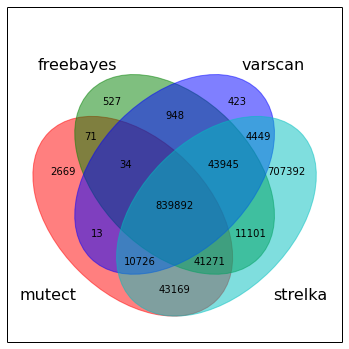

In [17]:
vn.venn([snpdf[snpdf.mutectallele != '']['chromPos'], \
         snpdf[snpdf.strelkaallele != '']['chromPos'], \
        snpdf[snpdf.freebayesallele != '']['chromPos'], \
        snpdf[snpdf.varscanallele != '']['chromPos'] \
        ],['mutect','strelka','freebayes','varscan'],figsize=(6,6))

<h3> Allelic Depth

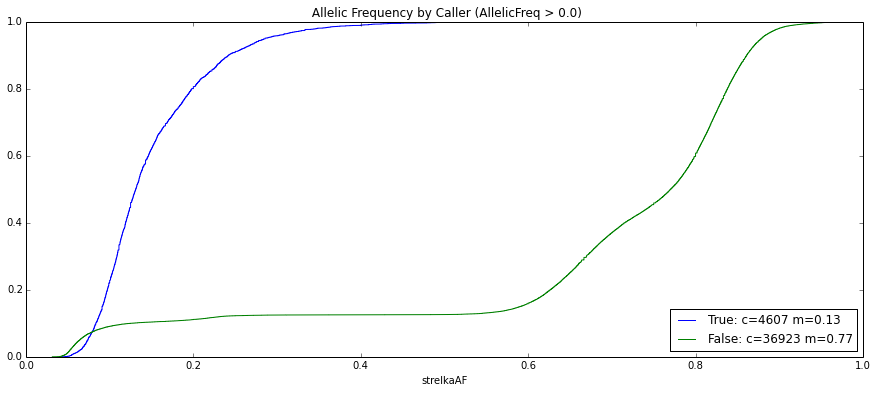

In [18]:
#Alllele Freq By Caller
for truth in [True,False]:
    ser = dfProd[(dfProd.Truth == truth)&(dfProd['filter']=='QSI_ref')]['strelkaAF']
    ser = ser.sort_values()
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser,name=str(truth)+": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
    ser_cdf.plot(drawstyle='steps',legend=True,title=" Allelic Frequency by Caller (AllelicFreq > 0.0)",figsize=[15,6],xlim=[0,1])

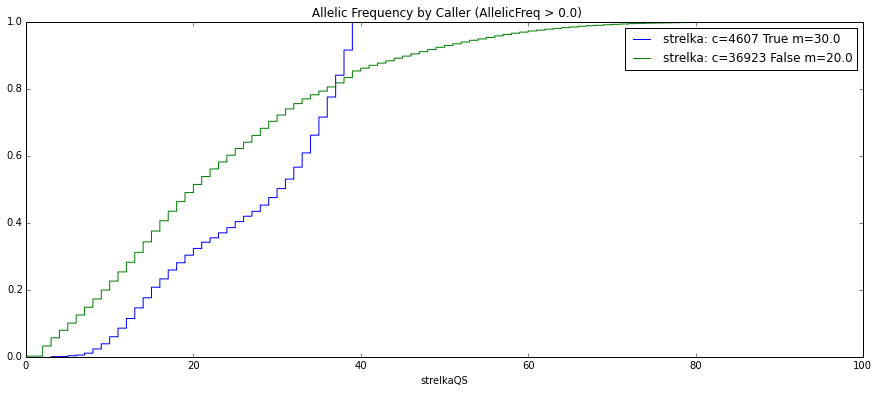

In [19]:
truths = [True,False]
for truth in truths:
    #Alllele Freq By Caller
    for columnName in list(dfProd):
        if columnName.endswith('strelkaQS'):
            ser = dfProd[(dfProd.Truth == truth)&(dfProd['filter']=='QSI_ref')][columnName]
            ser = ser.sort_values()
            cum_dist = np.linspace(0.,1.,len(ser))
            ser_cdf = pd.Series(cum_dist, index=ser,name=columnName[:-2]+": c="+str(ser.count())+ " "+ str(truth) +" m="+str(round(ser.median(),2)))
            ser_cdf.plot(drawstyle='steps',legend=True,title=" Allelic Frequency by Caller (AllelicFreq > 0.0)",figsize=[15,6],xlim=[0,100],ylim=[0,1])

### SCRATCH

In [20]:
dfProd[(dfProd.variantType=='INDEL')&(dfProd.Truth==False)&(dfProd.freebayesallele<>'')&(dfProd.chromPos.str.contains('1:'))].head(20)

chromPos  chromFrac id          ref                vennSegment  numCallers variantType variantSubType filter bedRegion inDBSNP inCOSMIC annGene annWorstImpact annWorstEffect annAllEffects consensus strelkaallele  strelkaAF strelkaDP strelkaQS strelkaSGT strelkaindelDiff strelkaSVLenMin strelkaSVLenMax strelkaSVStartMin strelkaSVStartMax varscanallele  varscanAF varscanDP varscanQS varscanSGT varscanindelDiff varscanSVLenMin varscanSVLenMax varscanSVStartMin varscanSVStartMax mutectallele  mutectAF mutectDP mutectQS mutectSGT mutectindelDiff mutectSVLenMin mutectSVLenMax mutectSVStartMin mutectSVStartMax freebayesallele  freebayesAF freebayesDP freebayesQS freebayesSGT freebayesindelDiff freebayesSVLenMin freebayesSVLenMax freebayesSVStartMin freebayesSVStartMax   patientName variantType_Truth  ref_Truth truthallele truthindelDiff bedRegion_Truth  hasTP  hasFP  Truth
chrom pos                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
1     100590778  1:100590778   1.403573  .          AGT          freebayes-varscan           2       INDEL         DELETE   PASS   Default   False    False                                                          True                -1.000000                                                                                                                                 A     0.1613        96        17          2              GT-                                                                                       -1.0                                                                                                                           A     0.202703          84      136.67          0/1                GT-                                                                              CPCT11111111               NaN        NaN         NaN            NaN             NaN  False  False  False
      109050528  1:109050528   1.437514  .            T                  freebayes           1       INDEL         INSERT      .   Default   False    False                                                         False                -1.000000                                                                                                                                      -1.0000                                                                                                                                       -1.0                                                                                                                       TACAC     0.283019          88      197.46          0/1              ACAC+                                                                              CPCT11111111             INDEL          T         TAC            AC+         Default  False   True  False
      114742526  1:114742526   1.460350  .            A  freebayes-filterInstrelka           1       INDEL         INSERT   PASS   Default   False    False                                                         False            AT   0.613333       112         3   ref->het               T+                                                                                      -1.0000                                         

In [21]:
dftemp[(dftemp.vennSegment.str.contains('mutect'))&(dftemp.Truth==False)].head(200)

NameError: name 'dftemp' is not defined

In [ ]:
pd.set_option('display.max_rows', 500)
dftemp[((dftemp.vennSegment.str.contains('mutect'))|(dftemp.vennSegment=='Intersection'))&(dftemp.Truth==True)].head(40)

In [ ]:
dftemp2[((dftemp2.vennSegment.str.contains('mutect'))|(dftemp2.vennSegment=='Intersection'))&(dftemp2.Truth==True)].head(40)

In [ ]:
len(dftemp)

In [ ]:
len(dftemp2)

In [ ]:
indeldf = dfProd[(dfProd.variantType == 'INDEL')].reset_index()

In [ ]:
indeldf.head()

In [ ]:
def calculateIndelLength(ref,alt):
        return len(str(alt))-len(str(ref))

In [ ]:
indeldf["indelLength"] = np.vectorize(calculateIndelLength)(indeldf['ref'], indeldf['meltedallele'])


In [ ]:
pd.set_option('display.max_rows', 100)
pd.pivot_table(indeldf, values='pos', index=['variantSubType','indelLength'], columns=['numCallers','Truth'], aggfunc='count').fillna(0)

In [ ]:
dfTruth.head()

In [ ]:
dfTruth["indelLength"] = np.vectorize(calculateIndelLength)(dfTruth['ref'], dfTruth['truthallele'])

In [ ]:

pd.pivot_table(dfTruth.reset_index(), values='pos', index=['indelLength'], columns=['variantType'], aggfunc='count').fillna(0)